In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
ratings_path="/content/drive/MyDrive/Dataset/ml-100k/u.data"
movies_path="/content/drive/MyDrive/Dataset/ml-100k/u.item"
users_path="/content/drive/MyDrive/Dataset/ml-100k/u.user"
genre_path="/content/drive/MyDrive/Dataset/ml-100k/u.genre"


In [3]:
ratings = pd.read_csv(ratings_path, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv(movies_path, sep='|', names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], encoding='latin-1')
users = pd.read_csv(users_path, sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

In [4]:
ratings = ratings.sort_values(by=['user_id', 'timestamp'])

In [5]:
sequences = ratings.groupby('user_id').apply(lambda x: list(zip(x['item_id'], x['rating']))).tolist()

In [6]:
max_seq_length = 50
sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post', value=(0, 0))


In [7]:
X = sequences[:, :-1]
y = sequences[:, 1:, 1]

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Model

In [10]:
from tensorflow.keras.layers import Concatenate

In [11]:
#LSTM

input_layer = Input(shape=(max_seq_length - 1, 2), name='input_layer')
item_input = input_layer[:, :, 0]
item_embedding = Embedding(input_dim=len(movies['item_id'].unique()) + 1, output_dim=50)(item_input)

# Wrap tf.expand_dims in a Lambda layer
expanded_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, -1))(input_layer[:, :, 1])

x = Concatenate()([item_embedding, expanded_input]) # Use the wrapped tensor here
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64, return_sequences=True)(x)
output_layer = TimeDistributed(Dense(1))(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 49, 2)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 49)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 49)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 49, 50)         │         84,150 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 49, 1)          │              0 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 49, 51)         │              0 │ embedding[0][0],       │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 49, 128)        │         92,160 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 49, 64)         │         49,408 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 49, 1)          │             65 │ lstm_1[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 225,783 (881.96 KB)

 Trainable params: 225,783 (881.96 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 5.3512 - mae: 1.8587 - val_loss: 1.8833 - val_mae: 1.0627
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 1.6850 - mae: 0.9802 - val_loss: 1.4599 - val_mae: 0.9051
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - loss: 1.3786 - mae: 0.8633 - val_loss: 1.3107 - val_mae: 0.8479
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 1.2252 - mae: 0.8104 - val_loss: 1.2333 - val_mae: 0.8181
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 1.1842 - mae: 0.7991 - val_loss: 1.1830 - val_mae: 0.8067
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 1.1263 - mae: 0.7759 - val_loss: 1.1522 - val_mae: 0.8011
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 1.0797 - mae: 0.7586 - val_loss: 1.1154 - val_mae: 0.7796
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 1.0509 - mae: 0.7490 - val_loss: 1.0985 - val_mae: 0.7841
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - lo

In [13]:
import matplotlib.pyplot as plt

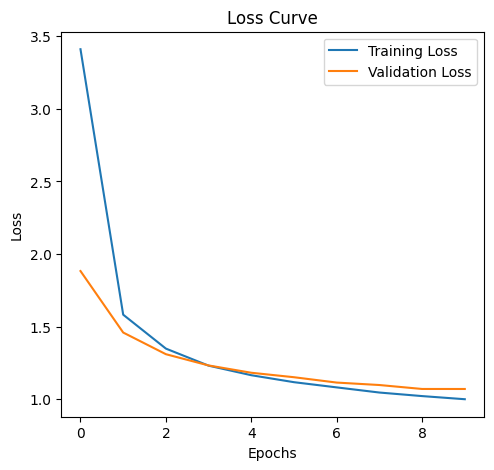

In [14]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

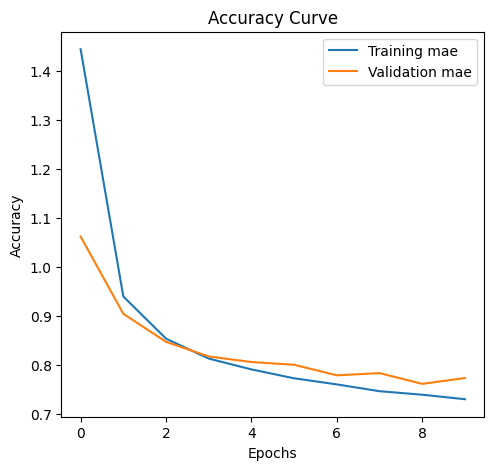

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training mae')
plt.plot(history.history['val_mae'], label='Validation mae')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [16]:
def get_user_sequence(user_id, user_item_matrix, max_sequence_length):
    user_sequence = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index.tolist()
    padded_sequence = pad_sequences([user_sequence], maxlen=max_sequence_length)
    return padded_sequence

def predict_next_movie(user_id, model, user_item_matrix, max_sequence_length):
    user_sequence = get_user_sequence(user_id, user_item_matrix, max_sequence_length)
    predictions = model.predict(user_sequence)
    return predictions

def recommend_movies(user_id, model, user_item_matrix, movie_titles, top_n=10):
    predictions = predict_next_movie(user_id, model, user_item_matrix, max_sequence_length)
    top_movie_indices = predictions[0].argsort()[-top_n:][::-1]
    recommended_movies = movie_titles.iloc[top_movie_indices].index.tolist()
    return recommended_movies


In [17]:
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

In [18]:
movie_titles = pd.read_csv(movies_path, sep='|', names=['movie_id', 'title'], usecols=[0, 1], encoding='latin-1')
movie_titles.set_index('movie_id', inplace=True)

In [19]:
max_sequence_length = 50

In [20]:
# Evaluate the model
loss, mae = model.evaluate(X_val, y_val)
print(f'Validation MAE: {mae}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0618 - mae: 0.7638
Validation MAE: 0.7740979790687561


In [21]:
print(X_val[:1])

[[[135   5]
  [408   5]
  [482   5]
  [168   4]
  [430   5]
  [132   5]
  [496   2]
  [ 98   4]
  [173   3]
  [435   4]
  [ 28   5]
  [192   1]
  [100   2]
  [ 79   5]
  [174   4]
  [661   5]
  [205   2]
  [603   4]
  [ 83   1]
  [194   3]
  [228   5]
  [655   5]
  [429   4]
  [222   5]
  [189   4]
  [169   5]
  [  1   4]
  [183   5]
  [ 89   5]
  [  7   5]
  [172   4]
  [484   3]
  [204   5]
  [195   5]
  [432   4]
  [193   4]
  [466   3]
  [202   5]
  [ 50   5]
  [191   5]
  [423   5]
  [357   5]
  [115   5]
  [ 97   5]
  [ 82   4]
  [428   4]
  [ 23   5]
  [186   3]
  [919   5]]]


In [22]:
# Make predictions
predictions = model.predict(X_val)
print(predictions[:1])

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step
[[[2.2012286]
  [3.7576647]
  [4.461967 ]
  [4.236305 ]
  [4.269475 ]
  [4.3517127]
  [4.105652 ]
  [4.1174107]
  [3.9827912]
  [4.070794 ]
  [4.2571754]
  [3.2957306]
  [3.5129592]
  [3.7992854]
  [3.8556921]
  [3.850622 ]
  [3.459517 ]
  [3.7987478]
  [3.2052026]
  [3.2404134]
  [3.746451 ]
  [3.7700489]
  [3.7244961]
  [3.7396367]
  [3.7703764]
  [3.7646096]
  [3.815974 ]
  [4.1386347]
  [3.9898121]
  [4.1095   ]
  [3.9502306]
  [3.5528371]
  [3.9925838]
  [4.089228 ]
  [3.9358246]
  [4.0830297]
  [3.7720268]
  [4.1424465]
  [4.0442705]
  [4.1410394]
  [4.127845 ]
  [4.046728 ]
  [4.1300526]
  [4.2573385]
  [3.7821991]
  [3.7553995]
  [4.101718 ]
  [3.8330886]
  [4.0083766]]]


In [23]:
movie_dict = movies.set_index('item_id')['title'].to_dict()

In [24]:
import numpy as np

def map_predictions_to_movie_names(predictions, movie_dict, X_val):
    movie_names = []
    for user_idx, user_preds in enumerate(predictions):
        user_movie_names = []
        for movie_idx, movie_pred in enumerate(user_preds):
            item_id = X_val[user_idx, movie_idx, 0]
            if item_id != 0:  # Ignore padding
                movie_name = movie_dict.get(item_id, "Unknown Movie")
                user_movie_names.append((movie_name, movie_pred[0]))
        movie_names.append(user_movie_names)
    return movie_names

# Get movie names with predicted ratings
mapped_predictions = map_predictions_to_movie_names(predictions, movie_dict, X_val)

# Print the first user's predictions
for movie_name, pred_rating in mapped_predictions[0]:
    print(f"Movie: {movie_name}, Predicted Rating: {pred_rating}")


Movie: 2001: A Space Odyssey (1968), Predicted Rating: 2.201228618621826
Movie: Close Shave, A (1995), Predicted Rating: 3.757664680480957
Movie: Some Like It Hot (1959), Predicted Rating: 4.4619669914245605
Movie: Monty Python and the Holy Grail (1974), Predicted Rating: 4.236305236816406
Movie: Duck Soup (1933), Predicted Rating: 4.269474983215332
Movie: Wizard of Oz, The (1939), Predicted Rating: 4.351712703704834
Movie: It's a Wonderful Life (1946), Predicted Rating: 4.10565185546875
Movie: Silence of the Lambs, The (1991), Predicted Rating: 4.117410659790039
Movie: Princess Bride, The (1987), Predicted Rating: 3.9827911853790283
Movie: Butch Cassidy and the Sundance Kid (1969), Predicted Rating: 4.070794105529785
Movie: Apollo 13 (1995), Predicted Rating: 4.257175445556641
Movie: Raging Bull (1980), Predicted Rating: 3.2957305908203125
Movie: Fargo (1996), Predicted Rating: 3.5129592418670654
Movie: Fugitive, The (1993), Predicted Rating: 3.799285411834717
Movie: Raiders of the Lo

In [25]:
def get_movie_names_from_sequences(sequences, movie_dict):
    movie_names = []
    for sequence in sequences:
        sequence_movie_names = []
        for item_id, rating in sequence:
            if item_id != 0:  # Skip padding
                sequence_movie_names.append(movie_dict[item_id])
        movie_names.append(sequence_movie_names)
    return movie_names

In [26]:
X_val_sequences = [
    [(X_val[i, j, 0], X_val[i, j, 1]) for j in range(X_val.shape[1])]
    for i in range(X_val.shape[0])
]

In [28]:
X_val_movie_names = get_movie_names_from_sequences(X_val_sequences, movie_dict)

# Print some examples
for i in range(1):
    print(f"User {i+1} sequence of movie names: {X_val_movie_names[i]}")

User 1 sequence of movie names: ['2001: A Space Odyssey (1968)', 'Close Shave, A (1995)', 'Some Like It Hot (1959)', 'Monty Python and the Holy Grail (1974)', 'Duck Soup (1933)', 'Wizard of Oz, The (1939)', "It's a Wonderful Life (1946)", 'Silence of the Lambs, The (1991)', 'Princess Bride, The (1987)', 'Butch Cassidy and the Sundance Kid (1969)', 'Apollo 13 (1995)', 'Raging Bull (1980)', 'Fargo (1996)', 'Fugitive, The (1993)', 'Raiders of the Lost Ark (1981)', 'High Noon (1952)', 'Patton (1970)', 'Rear Window (1954)', 'Much Ado About Nothing (1993)', 'Sting, The (1973)', 'Star Trek: The Wrath of Khan (1982)', 'Stand by Me (1986)', 'Day the Earth Stood Still, The (1951)', 'Star Trek: First Contact (1996)', 'Grand Day Out, A (1992)', 'Wrong Trousers, The (1993)', 'Toy Story (1995)', 'Alien (1979)', 'Blade Runner (1982)', 'Twelve Monkeys (1995)', 'Empire Strikes Back, The (1980)', 'Maltese Falcon, The (1941)', 'Back to the Future (1985)', 'Terminator, The (1984)', 'Fantasia (1940)', 'Rig